In [1]:
%load_ext autoreload
from ddls.distributions.custom_skew_norm import CustomSkewNorm
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_run
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_sweep

from ddls.plotting.plotting import PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import copy

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-28 11:23:50,022	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.callbacks` has been deprecated. Use `ray.rllib.algorithms.callbacks` instead. This will raise an error in the future!


Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-09-28 11:24:01,820	INFO worker.py:1510 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 


In [4]:
agent_to_sweep_path = {
    
    'Ape-X DQN': 'ong/ddls-scripts/gjt728tc ',
    
}

In [12]:
%autoreload

# load agent sweep
keys_to_ignore = ['training/'] # for ignoring data not needed for plotting
key_substrings_to_remove = ['evaluation/'] # for tidying up keys
verbose = False
agent_to_episode_stats_dict, agent_to_episode_completion_stats_dict, agent_to_episode_blocked_stats_dict = load_ramp_cluster_environment_metrics_from_wandb_sweep(agent_to_sweep_path, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove, verbose=verbose)

# convert dicts to dataframes
agent_episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(agent_episode_stats_df)

agent_episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(agent_episode_completion_stats_df)

agent_episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(agent_episode_blocked_stats_df)


Agent Ape-X DQN sweep <Sweep ong/ddls-scripts/gjt728tc (RUNNING)> parameters:
	algo.algo_config.n_step:
		{'values': [1, 3, 5, 10]}
	algo.algo_config.replay_buffer_config.prioritized_replay_alpha:
		{'values': [0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
	algo.algo_config.replay_buffer_config.prioritized_replay_beta:
		{'values': [0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
	algo.algo_config.target_network_update_freq:
		{'values': [1000, 10000, 100000]}
	algo.algo_config.v_max:
		{'values': [1, 10, 100, 200, 1000]}
	algo.algo_config.v_min:
		{'values': [-1, -10, -100, -200, -1000]}
	epoch_loop.rllib_config.gamma:
		{'values': [0.99, 0.993, 0.997, 0.999, 0.9999]}
	epoch_loop.rllib_config.lr:
		{'distribution': 'log_uniform_values', 'max': 0.001, 'min': '1e-05'}
Loading data from 20 runs...
Loaded data for run 1 of 20 (<Run ong/ddls-scripts/5ev7eiuz (crashed)>) in 0.873.
Loaded data for run 2 of 20 (<Run ong/ddls-scripts/6dhmbnwp (crashed)>) in 1.242.
Loaded data for run 3 of 20 (<Run ong/ddls-scripts

,episode_reward_max,flow_info_processed_mean,mean_demand_compute_throughput_mean,dep_info_processed_mean,dep_info_processed_min,num_jobs_blocked_max,mean_flow_throughput_min,acceptance_rate_min,num_jobs_completed_max,mean_flow_throughput_max,...,Agent,config,algo.algo_config.n_step,algo.algo_config.replay_buffer_config.prioritized_replay_alpha,algo.algo_config.replay_buffer_config.prioritized_replay_beta,algo.algo_config.target_network_update_freq,algo.algo_config.v_max,algo.algo_config.v_min,epoch_loop.rllib_config.gamma,epoch_loop.rllib_config.lr
0,-200,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,200,0.000000e+00,0.000000,0,0.000000e+00,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
1,-200,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,200,0.000000e+00,0.000000,0,0.000000e+00,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
2,-200,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,200,0.000000e+00,0.000000,0,0.000000e+00,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
3,-104,7.984768e+11,3.152576e+06,1.104361e+12,8.948142e+11,158,3.308642e+06,0.208955,45,4.405537e+06,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
4,-126,8.065346e+11,3.270182e+06,1.135702e+12,1.035101e+12,174,3.802501e+06,0.129353,35,4.447354e+06,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,-46,1.298587e+12,5.332053e+06,1.846522e+12,1.655128e+12,135,5.862682e+06,0.323383,72,6.995058e+06,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1795,-58,1.072879e+12,4.348706e+06,1.510461e+12,1.425481e+12,141,5.091791e+06,0.293532,68,5.893673e+06,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1796,-28,1.327228e+12,5.484442e+06,1.879198e+12,1.803964e+12,129,6.377277e+06,0.353234,80,7.094460e+06,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1797,-46,1.215390e+12,5.005166e+06,1.723179e+12,1.636566e+12,137,5.795788e+06,0.313433,74,6.217774e+06,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448


,job_completion_time_speedup_mean,jobs_completed_total_dependency_size_max,jobs_completed_max_acceptable_job_completion_time_mean,job_communication_overhead_time_max,jobs_completed_num_mounted_workers_min,job_completion_time_speedup_min,jobs_completed_max_partitions_per_op_mean,jobs_completed_max_acceptable_job_completion_time_frac_mean,jobs_completed_num_edges_max,jobs_completed_max_acceptable_job_completion_time_frac_min,...,Agent,config,algo.algo_config.n_step,algo.algo_config.replay_buffer_config.prioritized_replay_alpha,algo.algo_config.replay_buffer_config.prioritized_replay_beta,algo.algo_config.target_network_update_freq,algo.algo_config.v_max,algo.algo_config.v_min,epoch_loop.rllib_config.gamma,epoch_loop.rllib_config.lr
0,3.797222,2.801861e+10,15138.846488,0,6.190476,3.633062,5.115344,0.416259,514.095238,0.409286,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
1,2.888067,4.020345e+10,16531.830240,0,4.628571,2.825581,4.758608,0.473612,634.269231,0.461714,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
2,5.294502,3.419864e+10,12698.181448,0,10.333333,4.569812,11.825256,0.374649,738.021277,0.308085,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
3,6.503196,2.971071e+10,12042.815414,0,15.040000,5.886134,15.535072,0.334457,846.869565,0.316304,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
4,6.282267,2.610211e+10,12902.454757,0,14.625000,5.849788,14.933761,0.360470,789.791667,0.350577,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,3.805388,2.621227e+10,13784.759298,0,6.472222,3.720882,5.747619,0.380262,536.785714,0.370857,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1731,3.872184,2.402678e+10,13471.616168,0,6.218750,3.742176,5.747258,0.392224,494.118644,0.373594,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1732,3.664953,2.460819e+10,13706.417703,0,5.800000,3.515902,5.273075,0.397105,517.136986,0.382375,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1733,3.753311,2.844848e+10,13554.549146,0,5.729730,3.661932,5.611504,0.387636,559.333333,0.378730,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448


,jobs_blocked_num_nodes_max,jobs_blocked_num_edges_max,jobs_blocked_original_demand_num_nodes_max,jobs_blocked_max_acceptable_job_completion_time_mean,jobs_blocked_original_demand_num_edges_mean,jobs_blocked_total_dependency_size_max,jobs_blocked_num_nodes_min,jobs_blocked_original_demand_num_nodes_min,jobs_blocked_original_demand_total_operation_memory_cost_min,jobs_blocked_original_demand_total_dependency_size_min,...,Agent,config,algo.algo_config.n_step,algo.algo_config.replay_buffer_config.prioritized_replay_alpha,algo.algo_config.replay_buffer_config.prioritized_replay_beta,algo.algo_config.target_network_update_freq,algo.algo_config.v_max,algo.algo_config.v_min,epoch_loop.rllib_config.gamma,epoch_loop.rllib_config.lr
0,101.140000,112.660000,101.140000,9439.727767,111.583333,1.704755e+10,99.760000,99.760000,1.584565e+10,1.614523e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
1,102.910000,114.990000,102.910000,9104.679923,112.420000,1.608249e+10,98.450000,98.450000,1.488103e+10,1.502648e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
2,101.900000,113.760000,101.900000,9107.468181,109.640000,1.596494e+10,95.060000,95.060000,1.556755e+10,1.576827e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
3,111.848101,126.164557,111.848101,7830.468186,117.969756,1.782718e+10,99.819355,99.819355,1.584752e+10,1.591774e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
4,97.290698,108.011628,97.290698,8017.328751,105.386321,1.623918e+10,91.551724,91.551724,1.327097e+10,1.310822e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.9,0.1,10000,1000,-10,0.999,0.000305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,104.107692,117.476923,104.107692,7075.403757,115.619430,1.738047e+10,102.074074,102.074074,1.504737e+10,1.509367e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1795,105.757576,118.939394,105.757576,6705.997425,117.407659,1.680212e+10,103.514706,103.514706,1.617160e+10,1.616784e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1796,103.333333,114.533333,103.333333,7232.661977,111.766620,1.887060e+10,98.771654,98.771654,1.620766e+10,1.624894e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448
1797,104.343750,117.968750,104.343750,6394.069691,114.988656,1.728335e+10,100.111111,100.111111,1.551862e+10,1.558477e+10,...,Ape-X DQN,"{""algo"": {""value"": {""model"": {""fcnet_hiddens"":...",5,0.5,0.1,100000,10,-200,0.997,0.000448


In [31]:
# set which metrics you want to plot
metrics = ['episode_reward', 'blocking_rate']

# apply rolling average to smoothen the lineplot data https://stackoverflow.com/questions/13996302/python-rolling-functions-for-groupby-object
rolling_window = 10
rolling_agent_episode_stats_df = copy.deepcopy(agent_episode_stats_df)
for metric in metrics:
    for extension in ['min', 'mean', 'max']:
        rolling_agent_episode_stats_df[f'{metric}_{extension}'] = agent_episode_stats_df.groupby('config')[f'{metric}_{extension}'].rolling(window=rolling_window).mean().reset_index(0, drop=True)

In [38]:
def lineplot(df, metric):
    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

    estimator = np.mean # np.mean np.median

    scaling_factor = 1
    # scaling_factor = 0.6
    width_scaling_factor = 1
    height_scaling_factor = 1

    # xaxis = 'mean_load_rate'
    # xaxis = episode_stats_df['grouped_mean_load_rate']
    # xaxis_label = 'Load\nRate (B/s)'
    # xaxis = None

    xaxis = agent_episode_stats_df['epoch_counter']
    xaxis_label = 'Learner Steps'
    # xaxis = agent_episode_stats_df['actor_step_counter']
    # xaxis_label = 'Actor Steps'
    # xaxis = agent_episode_stats_df['episode_counter']
    # xaxis_label = 'Episodes'
    # xaxis = agent_episode_stats_df['run_time']
    # xaxis_label = 'Training Time (Hours)' # will convert time units automatically ['Seconds', 'Minutes', 'Hours', 'Days']

    metric_to_yaxis_label = {
        'episode_reward': 'Episode Return',
        'blocking_rate': 'Blocking Rate',
    }

    hue = 'config'

    style = None
    # style = 'config'

    # errorbar = ('ci', 95)
    errorbar = 100 # plot all samples
    # errorbar = 95
    # errorbar = 'sd'

    markers = False
    # markers = True

    linewidth = aesthetics.linewidth

    # legend = 'auto'
    legend = None

    xlim = None
    # xlim = [0, 2]

    ylim = None
    # ylim = [20, 100]

    xaxis_label_style = 'plain' # sci plain
    yaxis_label_style = 'plain' # sci plain
    # yaxis_label_style = 'sci' # sci plain

    # ylog = True
    ylog = False
    # xlog = True
    xlog = False
    
    title = None

    use_manual_error_bars = True
    # use_manual_error_bars = False

    metric_to_goal = {
        'episode_reward': 'maximise',
        'blocking_rate': 'minimise',
    }
    
    # generate colour for each agent given hue order and colour palette
    palette = aesthetics.palette
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    print(f'Plotting metric {metric} -> min={np.min(df[metric+"_mean"])} | max={np.max(df[metric+"_mean"])} | mean={np.mean(df[metric+"_mean"])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    if use_manual_error_bars:
        # HACK: Go through and group mean, min, max into one y label so seaborn can plot min max error bars from RLlib min max summary
        # N.B. Since Seaborn will take its mean from RLlib min, max, mean rather than the original data RLlib got its mean from,
        # the mean value plotted by seaborn will be different from RLlib and biased by the min/max values.
        # You should check how different these are by setting use_manual_error_bars=True/False to see if it's a problem
        _df = defaultdict(list)
        _xaxis = []
        for extension in ['_mean', '_max', '_min']:
            metric_vals = df[metric+extension].tolist()
            hue_vals = df[hue].tolist()
            epoch_counter_vals = df['epoch_counter'].tolist()
            if xaxis is None:
                xaxis_vals = df.index.tolist()
            else:
                xaxis_vals = xaxis.tolist()
            _df[metric].extend(metric_vals)
            _df[hue].extend(hue_vals)
            _df['epoch_counter'].extend(epoch_counter_vals)
            _xaxis.extend(xaxis_vals)
        _df = pd.DataFrame(_df)
        _y = metric
        errorbar = 100 # plot all samples
    else:
        _df = df
        _y = metric + '_mean'
        if xaxis is None:
            _xaxis = df.index
        else:
            _xaxis = xaxis
        errorbar = 100
    
    if 'Training Time' in xaxis_label:
        units = xaxis_label.split('(')[-1].split(')')[0]
        _xaxis = np.array(_xaxis)
        if units == 'Seconds':
            xaxis = _xaxis
        elif units == 'Minutes':
            xaxis = _xaxis / 60
        elif units == 'Hours':
            xaxis = _xaxis / 60
            xaxis /= 60
        elif units == 'Days':
            xaxis = _xaxis / 60
            xaxis /= 60
            xaxis /= 24
        else:
            raise Exception(f'Unrecognised run_time xaxis label units {units}')
    else:
        xaxis = _xaxis
        
    
    g = sns.lineplot(data=_df, 
                     x=xaxis, 
                     y=_y, 
                     hue=hue, 
                     style=style,
                     markers=markers,
                     linewidth=linewidth,
                     legend=legend,
                     ci=errorbar,
                     palette=palette,
                    )
    
    if title is not None:
        plt.title(title)
    if xlim is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    if legend is not None:
        handles, lables = g.get_legend_handles_labels()
        for h in handles:
            h.set_markersize(2)
            h.set_linewidth(aesthetics.linewidth)
        ax.legend(loc='upper center', 
                  bbox_to_anchor=(0.5, 1.4), 
                  ncol=4, 
                  labelspacing=0.1, 
                  columnspacing=4, 
                  prop={'size': 6},
                  title=None,
                  frameon=False,
                 )
    g.set_xlabel(xaxis_label)
    g.set_ylabel(metric_to_yaxis_label[metric])
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    g.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric episode_reward -> min=-161.4 | max=-52.333333333333336 | mean=-81.4604832104832


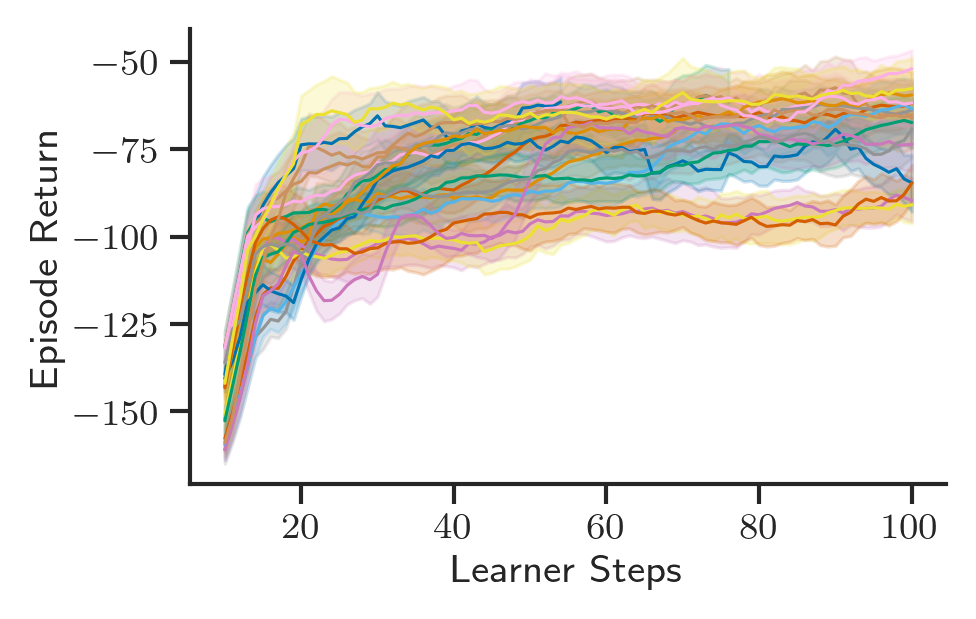

Plotting metric blocking_rate -> min=0.6421227197346601 | max=0.903150912106136 | mean=0.7123394086080652


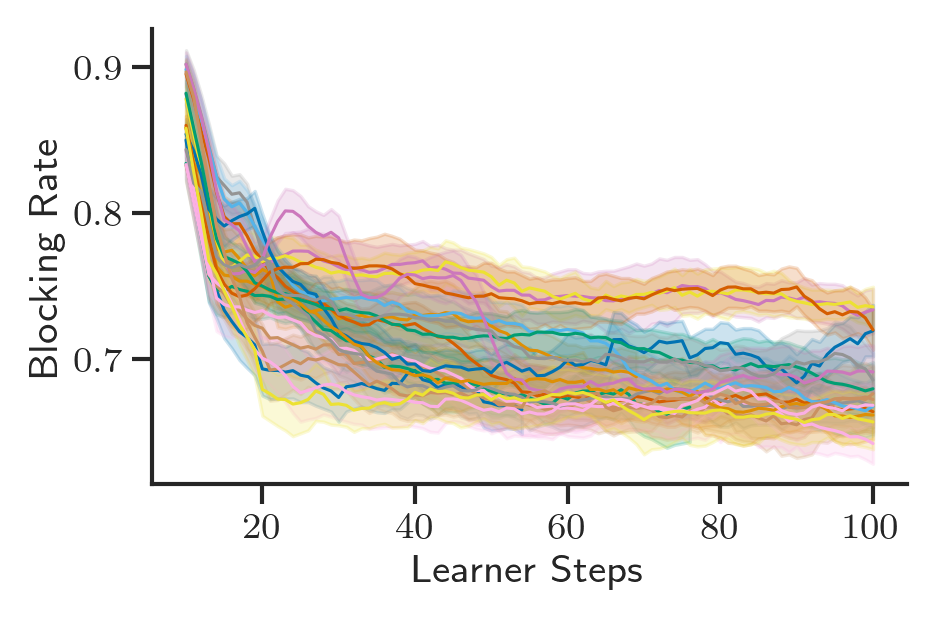

In [39]:
for metric in metrics:
    lineplot(df=rolling_agent_episode_stats_df, metric=metric)